In [1]:
import pandas as pd
import os

DATA_DIR = '../data/askme-qa/'

df_10k = pd.read_csv(os.path.join(DATA_DIR, 'raw_data_10k.csv'))
#df_full = pd.read_csv(os.path.join(DATA_DIR, 'askme-full.csv'))
#df_full.head()

In [31]:
import nltk
from collections import Counter
from nltk.util import ngrams
from tqdm.notebook import tqdm
import pandas as pd

nltk.download('punkt')

def get_top_ngrams(questions, n, top_k=None):
    ngram_counter = Counter()
    for question in questions:
        tokens = nltk.word_tokenize(question.lower())
        ngram_counter.update(ngrams(tokens, n))
    total = sum(ngram_counter.values())
    if not top_k:
        top_k = len(ngram_counter)
    return ngram_counter.most_common(top_k), total

def process_ngrams(questions, n_values, top_k=None):
    df_ngram = pd.DataFrame()
    for n in tqdm(n_values, desc="Processing n-grams"):
        top_ngrams, total = get_top_ngrams(questions, n, top_k)
        ngram_data = [(n, rank + 1, ' '.join(ngram), freq, freq / total) for rank, (ngram, freq) in enumerate(top_ngrams)]
        df_temp = pd.DataFrame(ngram_data, columns=['n', 'rank', 'ngram', 'frequency', 'relative_frequency'])
        df_ngram = pd.concat([df_ngram, df_temp], ignore_index=True)
    return df_ngram

questions_full = df_full['text_question'].tolist()
questions_10k = df_10k['text_question'].tolist()

if os.path.isfile(os.path.join(DATA_DIR, 'ngrams-sorted-full.csv')):
    df_ngram_full = pd.read_csv(os.path.join(DATA_DIR, 'ngrams-sorted-full.csv'))
else: 
    df_ngram_full = process_ngrams(questions_full, range(1, 9))
    df_ngram_full.to_csv(os.path.join(DATA_DIR, 'ngrams-sorted-full.csv'), index=False)

if os.path.isfile(os.path.join(DATA_DIR, 'ngrams-sorted-10k.csv')):
    df_ngram_10k = pd.read_csv(os.path.join(DATA_DIR, 'ngrams-sorted-10k.csv'))
else:
    df_ngram_10k = process_ngrams(questions_10k, range(1, 9))
    df_ngram_10k.to_csv(os.path.join(DATA_DIR, 'ngrams-sorted-10k.csv'), index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/yuehengzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def calculate_ratios(df_ngram, n_values, k_values):
    ratio_sums = {k: [] for k in k_values}
    top_1_percent_ratios = []
    total_counts = []
    
    for n in n_values:
        subset = df_ngram[df_ngram['n'] == n]
        ratios = subset['relative_frequency'].tolist()
        total_count = len(ratios)
        total_counts.append(total_count)
        sorted_ratios = sorted(ratios, reverse=True)
        
        top_1_percent_count = max(1, total_count // 100)
        top_1_percent_ratios.append(sum(sorted_ratios[:top_1_percent_count]))
        
        for k in k_values:
            top_k_ratios = sorted_ratios[:k]
            ratio_sums[k].append(sum(top_k_ratios))
    
    return ratio_sums, top_1_percent_ratios, total_counts

n_values = list(range(1, 9))
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

full_ratios, full_top_1_percent_ratios, full_total_counts = calculate_ratios(df_ngram_full, n_values, k_values)
tenk_ratios, tenk_top_1_percent_ratios, tenk_total_counts = calculate_ratios(df_ngram_10k, n_values, k_values)

full_ratios['Top 1%'] = full_top_1_percent_ratios
full_ratios['Total Count'] = full_total_counts
tenk_ratios['Top 1%'] = tenk_top_1_percent_ratios
tenk_ratios['Total Count'] = tenk_total_counts

print("Full Dataset Ratios:")
print(pd.DataFrame(full_ratios, index=[f'{n}-gram' for n in n_values]))

print("\n10k Dataset Ratios:")
print(pd.DataFrame(tenk_ratios, index=[f'{n}-gram' for n in n_values]))

Full Dataset Ratios:
               1         2         4         8        16        32        64       128       256    Top 1%  Total Count
1-gram  0.070127  0.121722  0.192177  0.282645  0.366971  0.439122  0.495817  0.543865  0.594093  0.790285       225341
2-gram  0.012443  0.020579  0.034592  0.054085  0.076930  0.101846  0.128201  0.156221  0.188636  0.555674      2833102
3-gram  0.005985  0.009742  0.015353  0.021712  0.028955  0.036571  0.045250  0.056512  0.070583  0.349700      7746848
4-gram  0.001171  0.002155  0.003817  0.006833  0.010576  0.014652  0.019334  0.024913  0.032069  0.216721     11370385
5-gram  0.000828  0.001615  0.002929  0.004286  0.006046  0.007897  0.010061  0.013021  0.016692  0.138364     13045387
6-gram  0.000841  0.001478  0.002053  0.002509  0.003083  0.003972  0.005079  0.006533  0.008325  0.091785     13511161
7-gram  0.000106  0.000190  0.000343  0.000598  0.000971  0.001425  0.002026  0.002843  0.004050  0.066537     13283368
8-gram  0.000060  0

In [2]:
df_10k.columns

Index(['_sa_instance_state_question', 'paragraph_id', 'scope', 'text_question',
       'timestamp', 'downvote', 'id_question', 'context', 'author_id',
       'upvote', 'turns', '_sa_instance_state_paragraph', 'page_name',
       'section_name', 'subsubsection_name', 'section_hierarchy', 'word_count',
       'within_page_order', 'id_paragraph', 'subsection_name',
       'text_paragraph', 'text_cleaned', 'is_bad', 'processed',
       '_sa_instance_state', 'prompt', 'username', 'id', 'model',
       '_sa_instance_state_answer', 'timestamp_answer', 'question_id',
       'author_id_answer', 'setting', 'id_answer', 'text',
       '_sa_instance_state_rating', 'text_rating', 'value', 'author_id_rating',
       'id_rating', 'answer_id', 'timestamp_rating'],
      dtype='object')

In [2]:
df_filtered = df_10k[df_10k['setting'] == 'zs']
df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split()))

grouped_data = df_filtered.groupby('value').agg(
    average_context_word_count=('context_word_count', 'mean'),
    count=('context_word_count', 'size')
)

grouped_data = grouped_data.sort_index(ascending=False)

for i in range(6):
    if i not in grouped_data.index:
        grouped_data.loc[i] = {'average_context_word_count': 0, 'count': 0}  # or np.nan, depending on how you want to handle missing values

grouped_data = grouped_data.reset_index()
grouped_data.columns = ['Difficulty Group (Reversed)', 'Average Context Word Count', 'Count']

grouped_data


/tmp/ipykernel_2607866/3286758304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split()))


,Difficulty Group (Reversed),Average Context Word Count,Count
0,5,103.072986,2110
1,4,109.525122,1234
2,3,61.400000,5
3,2,119.520999,1881
4,1,112.985655,3834
5,0,117.714744,936


In [13]:
df_filtered = df_10k[df_10k['setting'] == 'zs']
df_filtered['context_word_count'] = (df_filtered['text_cleaned'] + df_filtered['context']).apply(lambda x: len(x.split()))

grouped_data = df_filtered.groupby('value').agg(
    average_context_word_count=('context_word_count', 'median'),
    count=('context_word_count', 'size')
)

grouped_data = grouped_data.sort_index(ascending=False)

for i in range(6):
    if i not in grouped_data.index:
        grouped_data.loc[i] = {'average_context_word_count': 0, 'count': 0}  # or np.nan, depending on how you want to handle missing values

grouped_data = grouped_data.reset_index()
grouped_data.columns = ['Difficulty Group (Reversed)', 'Average Context Word Count', 'Count']

grouped_data

/tmp/ipykernel_2607866/2891706218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['context_word_count'] = (df_filtered['text_cleaned'] + df_filtered['context']).apply(lambda x: len(x.split()))


,Difficulty Group (Reversed),Average Context Word Count,Count
0,5,106.0,2110
1,4,111.0,1234
2,3,56.0,5
3,2,125.0,1881
4,1,118.0,3834
5,0,122.5,936


/tmp/ipykernel_2942652/1266589505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split())) + df_filtered['context'].apply(lambda x: len(x.split()))
/tmp/ipykernel_2942652/1266589505.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['word_count_bin'] = pd.cut(df_filtered['context_word_count'], bins=bins, right=False)
/tmp/ipykernel_2942652/1266589505.py:15: FutureWarning: The default of observed=False is

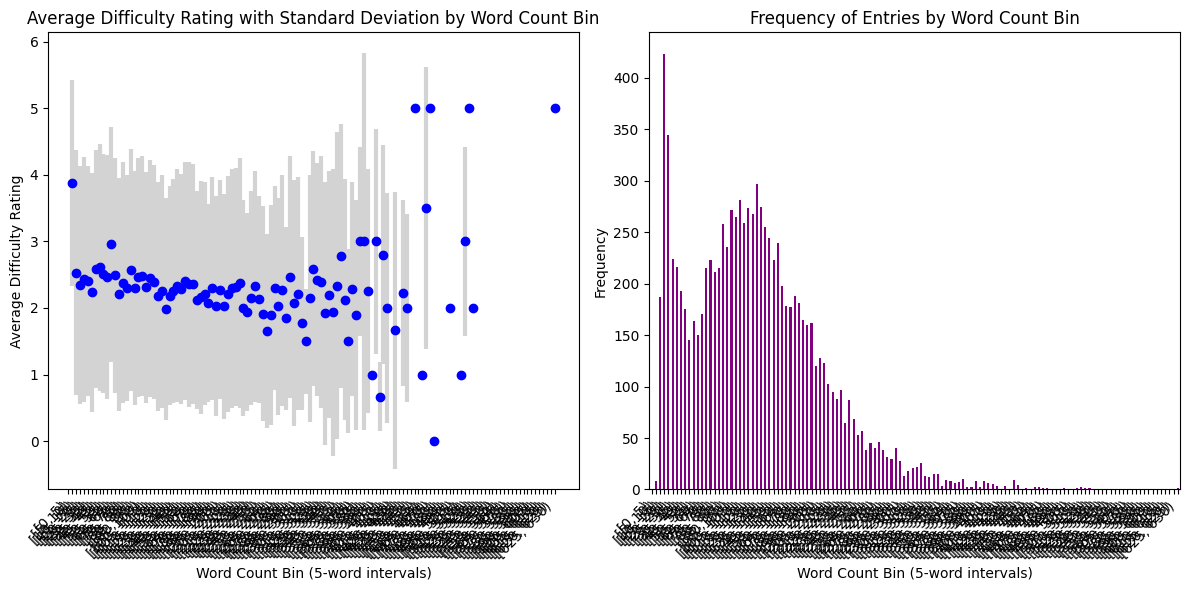

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame to only include rows where 'setting' is equal to 'zs'
df_filtered = df_10k[df_10k['setting'] == 'zs']

# Calculate the number of words in 'text_cleaned'
df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split())) + df_filtered['context'].apply(lambda x: len(x.split()))

# Create bins for word counts with a bin size of 5 words
bins = range(0, df_filtered['context_word_count'].max() + 5, 5)
df_filtered['word_count_bin'] = pd.cut(df_filtered['context_word_count'], bins=bins, right=False)

# Group by the word count bins and calculate the average, variance, and frequency for each bin
average_rating_per_bin = df_filtered.groupby('word_count_bin')['value'].mean()
variance_rating_per_bin = df_filtered.groupby('word_count_bin')['value'].var()
std_dev_per_bin = variance_rating_per_bin ** 0.5  # Standard deviation is the square root of variance
frequency_per_bin = df_filtered['word_count_bin'].value_counts(sort=False)

# Plot the combined average and standard deviation as error bars
plt.figure(figsize=(12, 6))

# Combined error bar plot for mean and standard deviation
plt.subplot(1, 2, 1)
plt.errorbar(average_rating_per_bin.index.astype(str), 
             average_rating_per_bin, 
             yerr=std_dev_per_bin, 
             fmt='o', 
             color='blue', 
             ecolor='lightgray', 
             elinewidth=3, 
             capsize=0)
plt.title('Average Difficulty Rating with Standard Deviation by Word Count Bin')
plt.xlabel('Word Count Bin (5-word intervals)')
plt.ylabel('Average Difficulty Rating')
plt.xticks(rotation=45, ha='right')

# Plot the frequency (number of entries in each bin)
plt.subplot(1, 2, 2)
frequency_per_bin.plot(kind='bar', color='purple')
plt.title('Frequency of Entries by Word Count Bin')
plt.xlabel('Word Count Bin (5-word intervals)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Show the combined plots
plt.tight_layout()
plt.show()


/tmp/ipykernel_2942652/1092659434.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['word_count_bin'] = pd.cut(df_filtered['context_word_count'], bins=bins, right=False)
/tmp/ipykernel_2942652/1092659434.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rating_per_bin = df_filtered.groupby('word_count_bin')['value'].mean()
/tmp/ipykernel_2942652/1092659434.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

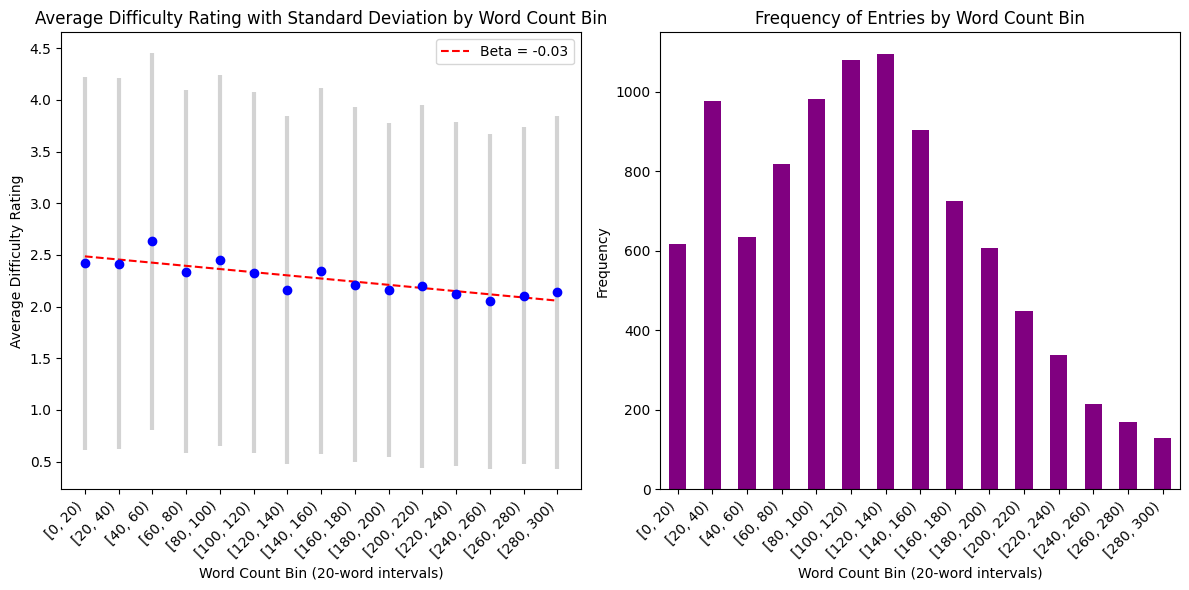

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming you have a DataFrame 'df_10k' with columns 'text_cleaned', 'value', and 'setting'

# Create bins for word counts with a bin size of 20 words
bins = range(0, df_filtered['context_word_count'].max() + 20, 20)
df_filtered['word_count_bin'] = pd.cut(df_filtered['context_word_count'], bins=bins, right=False)

# Group by the word count bins and calculate the average, variance, and frequency for each bin
average_rating_per_bin = df_filtered.groupby('word_count_bin')['value'].mean()
variance_rating_per_bin = df_filtered.groupby('word_count_bin')['value'].var()
std_dev_per_bin = variance_rating_per_bin ** 0.5  # Standard deviation is the square root of variance
frequency_per_bin = df_filtered['word_count_bin'].value_counts(sort=False)

# Filter out bins with fewer than 100 entries
valid_bins = frequency_per_bin[frequency_per_bin >= 100].index
average_rating_per_bin = average_rating_per_bin.loc[valid_bins]
std_dev_per_bin = std_dev_per_bin.loc[valid_bins]
frequency_per_bin = frequency_per_bin.loc[valid_bins]

# Prepare data for regression
x = np.arange(len(average_rating_per_bin))  # Treat bin indices as numerical values for regression
y = average_rating_per_bin.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Regression line
regression_line = slope * x + intercept

# Plot the combined average and standard deviation as error bars
plt.figure(figsize=(12, 6))

# Combined error bar plot for mean and standard deviation with regression line
plt.subplot(1, 2, 1)
plt.errorbar(average_rating_per_bin.index.astype(str), 
             average_rating_per_bin, 
             yerr=std_dev_per_bin, 
             fmt='o', 
             color='blue', 
             ecolor='lightgray', 
             elinewidth=3, 
             capsize=0)

# Plot the regression line
plt.plot(average_rating_per_bin.index.astype(str), regression_line, color='red', linestyle='--', label=f'Beta = {slope:.2f}')

plt.title('Average Difficulty Rating with Standard Deviation by Word Count Bin')
plt.xlabel('Word Count Bin (20-word intervals)')
plt.ylabel('Average Difficulty Rating')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Plot the frequency (number of entries in each bin)
plt.subplot(1, 2, 2)
frequency_per_bin.plot(kind='bar', color='purple')
plt.title('Frequency of Entries by Word Count Bin')
plt.xlabel('Word Count Bin (20-word intervals)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Show the combined plots
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd

df_filtered = df_10k[df_10k['setting'] == 'zs']
df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split()))

grouped_data = df_filtered.groupby('value').agg(
    average_context_word_count=('context_word_count', 'mean'),
    count=('context_word_count', 'size')
)
grouped_data = grouped_data.sort_index(ascending=False)

for i in range(6):
    if i not in grouped_data.index:
        grouped_data.loc[i] = {'average_context_word_count': 0, 'count': 0}  # or np.nan, depending on how you want to handle missing values

grouped_data = grouped_data.reset_index()
grouped_data.columns = ['Difficulty Group (Reversed)', 'Average Context Word Count', 'Count']

print(grouped_data)

print("\nExamples for each Difficulty Group:\n")
for value in sorted(df_filtered['value'].unique(), reverse=True):
    examples = df_filtered[df_filtered['value'] == value].head(3) 
    print(f"Difficulty Group {value}:")
    for idx, row in examples.iterrows():
        print(f"- {row['text_question']}")  
        print(f"  - Context: {row['context'] + row['text_cleaned']}")
    print("\n" + "-"*50 + "\n")

   Difficulty Group (Reversed)  Average Context Word Count  Count
0                            5                  103.072986   2110
1                            4                  109.525122   1234
2                            3                   61.400000      5
3                            2                  119.520999   1881
4                            1                  112.985655   3834
5                            0                  117.714744    936

Examples for each Difficulty Group:

Difficulty Group 5:
- Which team did the New England Patriots upset in Super Bowl XXXVI?
  - Context: In an article about '2004 World Series', section 'Aftermath'This World Series win by the Red Sox continued a trend of Boston teams beating St. Louis teams to win championships . Previously , in Super Bowl XXXVI , the New England Patriots had upset the St. Louis Rams ' " Greatest Show on Turf " , the Boston Bruins had swept the St. Louis Blues in the 1970 Stanley Cup Finals ( with Game 4 being re

/tmp/ipykernel_2607866/3806354302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split()))


In [16]:
import pandas as pd

# Assuming you have a DataFrame 'df_full' with columns 'text_cleaned', 'value', and 'setting'

# Filter the DataFrame to only include rows where 'setting' is equal to 'zs'
df_filtered = df_full[df_full['setting'] == 'zs']

# Calculate the number of words in 'text_cleaned'
df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split()))

# Group by 'value' and calculate the average number of words and count for each group
grouped_data = df_filtered.groupby('value').agg(
    average_context_word_count=('context_word_count', 'mean'),
    count=('context_word_count', 'size')
)

# Reverse the difficulty group order (value 0 as hardest and value 5 as easiest)
grouped_data = grouped_data.sort_index(ascending=False)

# Ensure there are 6 rows, one for each difficulty level from 0 to 5
for i in range(6):
    if i not in grouped_data.index:
        grouped_data.loc[i] = {'average_context_word_count': 0, 'count': 0}  # or np.nan, depending on how you want to handle missing values

# Convert the index into a column for clarity
grouped_data = grouped_data.reset_index()
grouped_data.columns = ['Difficulty Group (Reversed)', 'Average Context Word Count', 'Count']

# Display the DataFrame
print(grouped_data)


   Difficulty Group (Reversed)  Average Context Word Count   Count
0                            5                  107.702714  131631
1                            4                  114.185546   65008
2                            3                  132.583756     197
3                            2                  121.826815   72102
4                            1                  113.673841   80792
5                            0                  123.399816    6528


/tmp/ipykernel_2483658/1039357134.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['context_word_count'] = df_filtered['text_cleaned'].apply(lambda x: len(x.split()))
